In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic
from kid_readout.analysis.timeseries import filters

In [2]:
npd = npy.NumpyDirectory('/data/readout/2017-11-28_145238_mmw_source.npd/')

In [3]:
print(npd.metadata.script_code)

"""
Measure resonators, one at a time, with the readout tone centered in the filterbank bin.
"""
from __future__ import division
import time


import numpy as np

from kid_readout.roach import analog, calculate, hardware_tools, tools
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware, starcryo_temps
from equipment.srs import lockin
from equipment.custom import mmwave_source
from kid_readout.settings import LOCKIN_SERIAL_PORT

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)

# Parameters
suffix = 'mmw_source'
attenuations = [10, 20]
f_center = 1e6 * np.array([
    2757.5,
    2778.3,
    2792.0,
    2816.0,
    2872.0,  # low Q
    2921.5,
    2998.5,
    3001.0,
    3085.0,
    3229.0,
    3316.5,
    3347.0,
    3370.5,
    3420.5,
    3922.0  # no-man's land
    ])
#f_center = 1e6 * np.array([3420.5])
fractional_frequency_shift = 0
f_center *= (1 + fractional_frequency_shift)
df_baseband_target 

In [4]:
npd.node_names()

['SingleSweep0',
 'SingleSweepStreamList1',
 'ADCSnap2',
 'SingleSweep3',
 'SingleSweepStreamList4',
 'ADCSnap5',
 'SingleSweep6',
 'SingleSweepStreamList7',
 'ADCSnap8',
 'SingleSweep9',
 'SingleSweepStreamList10',
 'ADCSnap11',
 'SingleSweep12',
 'SingleSweepStreamList13',
 'ADCSnap14',
 'SingleSweep15',
 'SingleSweepStreamList16',
 'ADCSnap17',
 'SingleSweep18',
 'SingleSweepStreamList19',
 'ADCSnap20',
 'SingleSweep21',
 'SingleSweepStreamList22',
 'ADCSnap23',
 'SingleSweep24',
 'SingleSweepStreamList25',
 'ADCSnap26',
 'SingleSweep27',
 'SingleSweepStreamList28',
 'ADCSnap29',
 'SingleSweep30',
 'SingleSweepStreamList31',
 'ADCSnap32',
 'SingleSweep33',
 'SingleSweepStreamList34',
 'ADCSnap35',
 'SingleSweep36',
 'SingleSweepStreamList37',
 'ADCSnap38',
 'SingleSweep39',
 'SingleSweepStreamList40',
 'ADCSnap41',
 'SingleSweep42',
 'SingleSweepStreamList43',
 'ADCSnap44',
 'SingleSweep45',
 'SingleSweepStreamList46',
 'ADCSnap47',
 'SingleSweep48',
 'SingleSweepStreamList49',
 'AD

In [5]:
# The 20 dB data also has the funky noise
coarse = npd.SingleSweep54
sssl = npd.SingleSweepStreamList55
snap = npd.ADCSnap56

In [6]:
coarse.streams[0].roach_state.dac_attenuation

10.0

# ADCSnap

In [7]:
snap.x.ptp(), snap.y.ptp()

(37.0, 35.0)

# Coarse sweep

In [8]:
1e-6 * coarse.resonator.f_0

3229.477589668722

In [9]:
coarse.resonator.Q_e

(97126.1604084149+26030.12028676644j)

In [10]:
coarse.resonator.Q_i

19691.499181102678

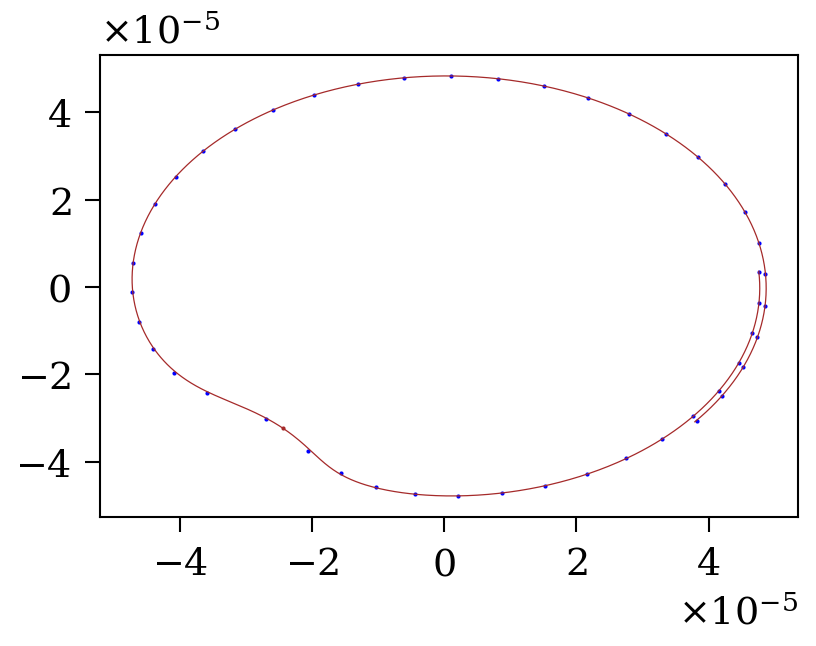

In [11]:
fig, ax = plt.subplots()
plot_basic.resonator_complex_plane(resonator=coarse.resonator, axis=ax, normalize=False);

# Fine sweep and streams

In [12]:
sss_off = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=sssl.stream_list[0], state=sssl.state)
sss_mod = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=sssl.stream_list[1], state=sssl.state)
sss_on = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=sssl.stream_list[2], state=sssl.state)

In [13]:
sss_off.stream.state.lockin.rms_voltage

0.0

In [14]:
sss_mod.stream.state.lockin.rms_voltage

0.00135422

In [15]:
sss_on.stream.state.lockin.rms_voltage

0.0402873

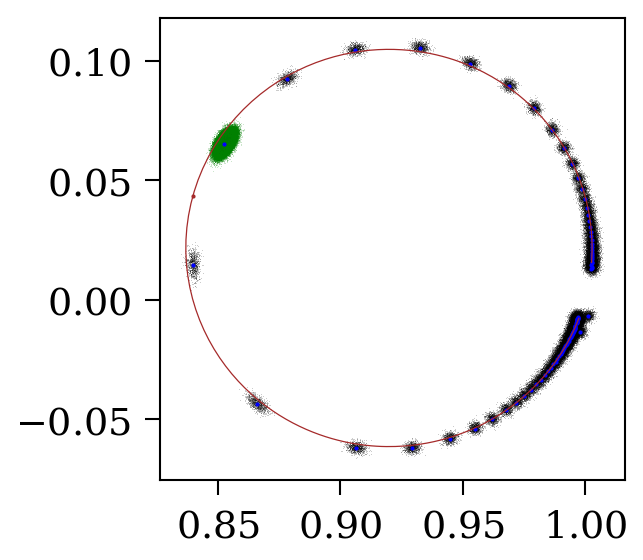

In [16]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.sss_complex_plane(sss=sss_off, axis=ax, normalize=True);

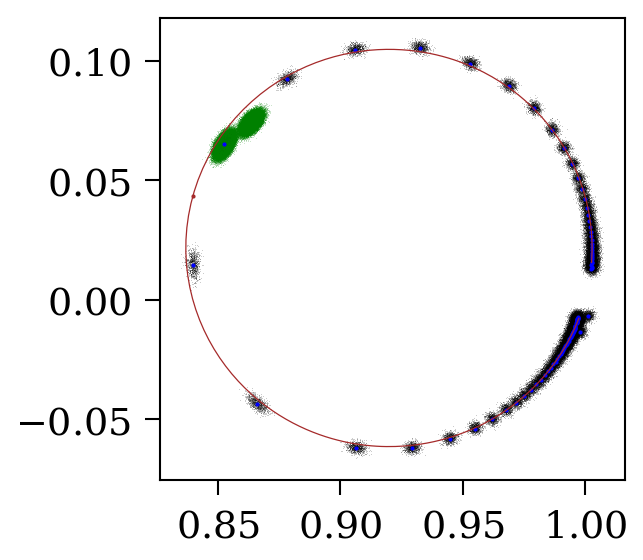

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.sss_complex_plane(sss=sss_mod, axis=ax, normalize=True);

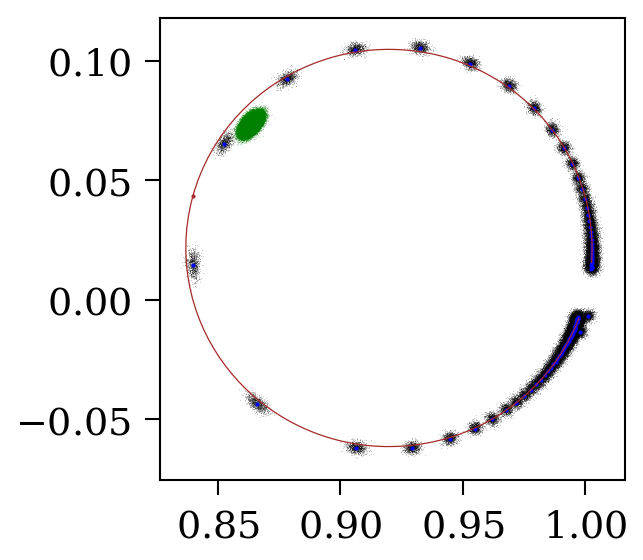

In [18]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.sss_complex_plane(sss=sss_on, axis=ax, normalize=True);

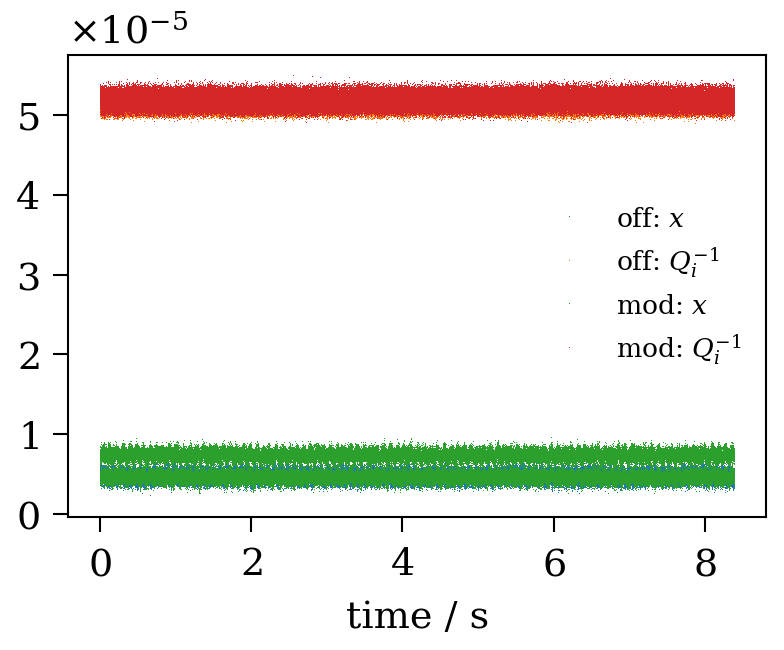

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel('time / s')
ax.plot(sss_off.stream.sample_time, sss_off.x, ',', label='off: $x$')
ax.plot(sss_off.stream.sample_time, sss_off.q, ',', label='off: $Q_i^{-1}$')
ax.plot(sss_mod.stream.sample_time, sss_mod.x, ',', label='mod: $x$')
ax.plot(sss_mod.stream.sample_time, sss_mod.q, ',', label='mod: $Q_i^{-1}$')
ax.legend(fontsize='xx-small');

In [20]:
def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

In [21]:
t_off, x_off, q_off = decimate(sss_off)
t_mod, x_mod, q_mod = decimate(sss_mod)
t_on, x_on, q_on = decimate(sss_on)

/home/flanigan/readout/kid_readout/kid_readout/analysis/timeseries/fftfilt.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i:k] = y[i:k] + yt[:k-i]            # and add


(0, 0.1)

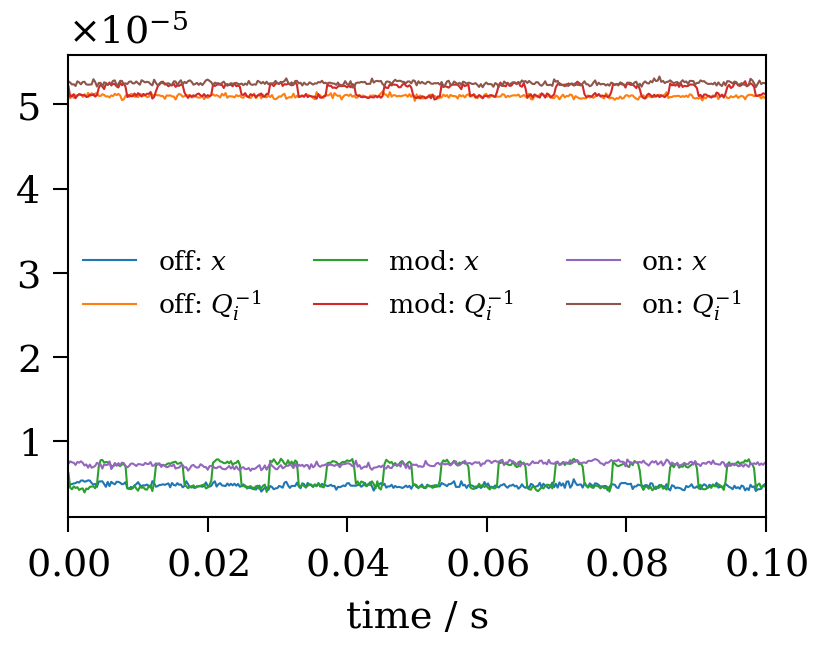

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('time / s')
ax.plot(t_off, x_off, '-', label='off: $x$')
ax.plot(t_off, q_off, '-', label='off: $Q_i^{-1}$')
ax.plot(t_mod, x_mod, '-', label='mod: $x$')
ax.plot(t_mod, q_mod, '-', label='mod: $Q_i^{-1}$')
ax.plot(t_on, x_on, '-', label='on: $x$')
ax.plot(t_on, q_on, '-', label='on: $Q_i^{-1}$')
ax.legend(fontsize='xx-small', ncol=3)
ax.set_xlim(0, 0.1)

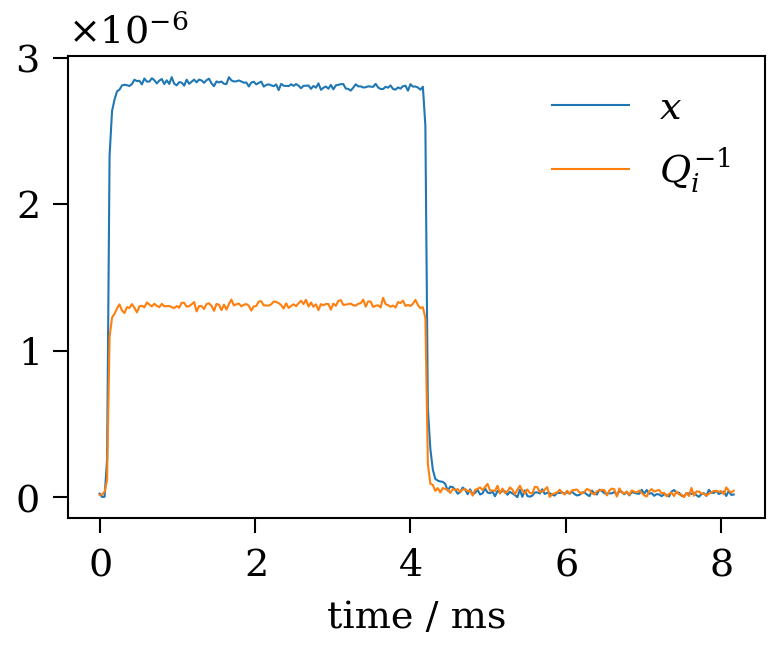

In [23]:
x_fold = sss_mod.fold(sss_mod.x)
q_fold = sss_mod.fold(sss_mod.q)
t = np.arange(x_fold.size) / sss_mod.stream.stream_sample_rate
fig, ax = plt.subplots()
ax.set_xlabel('time / ms')
ax.plot(1e3 * t, x_fold - x_fold.min(), label='$x$')
ax.plot(1e3 * t, q_fold - q_fold.min(), label='$Q_i^{-1}$')
ax.legend();

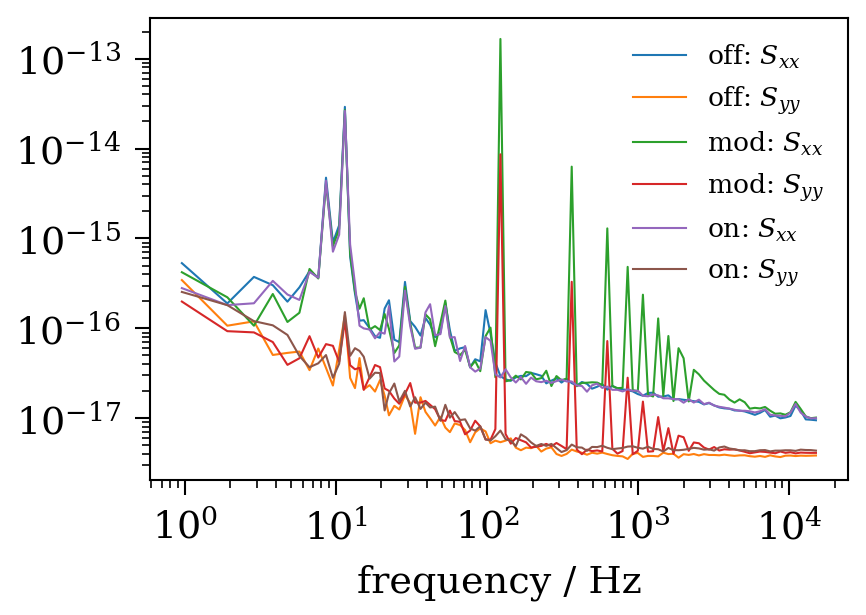

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / Hz')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
ax.plot(sss_off.S_frequency, sss_off.S_yy, label='off: $S_{yy}$')
ax.plot(sss_mod.S_frequency, sss_mod.S_xx, label='mod: $S_{xx}$')
ax.plot(sss_mod.S_frequency, sss_mod.S_yy, label='mod: $S_{yy}$')
ax.plot(sss_on.S_frequency, sss_on.S_xx, label='on: $S_{xx}$')
ax.plot(sss_on.S_frequency, sss_on.S_yy, label='on: $S_{yy}$')
ax.legend(fontsize='xx-small');